<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Natural language processing
## Custom embedddings using Gensim



In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform

import multiprocessing
from gensim.models import Word2Vec
from keras.preprocessing.text import text_to_word_sequence
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np
import plotly.graph_objects as go
import plotly.express as px



### Import dataset

In [2]:
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2022-03-29 04:04:40--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2022-03-29 04:04:40--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2022-03-29 04:04:40--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['Lil_Wayne.txt',
 'nickelback.txt',
 'ludacris.txt',
 'kanye-west.txt',
 'lin-manuel-miranda.txt',
 'patti-smith.txt',
 'britney-spears.txt',
 'prince.txt',
 'bruno-mars.txt',
 'leonard-cohen.txt',
 'dickinson.txt',
 'beatles.txt',
 'eminem.txt',
 'joni-mitchell.txt',
 'johnny-cash.txt',
 'lady-gaga.txt',
 'radiohead.txt',
 'kanye.txt',
 'jimi-hendrix.txt',
 'michael-jackson.txt',
 'rihanna.txt',
 'adele.txt',
 'janisjoplin.txt',
 'nicki-minaj.txt',
 'nirvana.txt',
 'nursery_rhymes.txt',
 'amy-winehouse.txt',
 'blink-182.txt',
 'drake.txt',
 'dj-khaled.txt',
 'missy-elliott.txt',
 'notorious-big.txt',
 'disney.txt',
 'bjork.txt',
 'bob-marley.txt',
 'bruce-springsteen.txt',
 'cake.txt',
 'dr-seuss.txt',
 'Kanye_West.txt',
 'dolly-parton.txt',
 'notorious_big.txt',
 'r-kelly.txt',
 'lorde.txt',
 'alicia-keys.txt',
 'al-green.txt',
 'bob-dylan.txt',
 'bieber.txt',
 'paul-simon.txt',
 'lil-wayne.txt']

In [4]:
df = pd.DataFrame()
for dataset in os.listdir("./songs_dataset/"):
    df_tmp = pd.read_csv(f'songs_dataset/{dataset}', sep='/n', header=None, engine="python")
    df = pd.concat([df, df_tmp])
df.head()

,0
0,They call me Mr Carter I kissed the daughter
1,Of the deads forehead I killed the father
2,Spilled the heart of a mildew hater
3,I will put them body on chill like glaciers
4,Gracias Im crazy yes its obvious


In [5]:
print("Number of documents:", df.shape[0])

Number of documents: 175960


### Preprocessing

In [6]:
sentence_tokens = []
# Transform sentence in sequence of words
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))
sentence_tokens[:2]

[['they', 'call', 'me', 'mr', 'carter', 'i', 'kissed', 'the', 'daughter'],
 ['of', 'the', 'deads', 'forehead', 'i', 'killed', 'the', 'father']]

### Create vectors (word2vec)

In [7]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.loss.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
            self.loss.append(loss - self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss
        

In [8]:
# Create vector generator model
w2v_model = Word2Vec(
    min_count=5,    # Minumum frequency of words to be included in the vocabulary
    window=2,       # Number of words before and after the predicted one
    size=300,       # Vectors dimentionality 
    negative=20,    # Number of negative samples
    workers=1,      # Number of workers
    sg=1,           # Model 0:CBOW  1:skipgram
)           

In [9]:
w2v_model.build_vocab(sentence_tokens)
print("Number of docs in the corpus:", w2v_model.corpus_count)
print("Number of distinct words in the copus:", len(w2v_model.wv.vocab))

Number of docs in the corpus: 175960
Number of distinct words in the copus: 10029


### Train generator model

In [10]:
# Train the generator model
train_callback = callback()
w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=50,
    compute_loss = True,
    callbacks=[train_callback]
)

Loss after epoch 0: 6979081.5
Loss after epoch 1: 5439422.5
Loss after epoch 2: 5159742.0
Loss after epoch 3: 4834668.0
Loss after epoch 4: 4711020.0
Loss after epoch 5: 4614962.0
Loss after epoch 6: 4412464.0
Loss after epoch 7: 4260568.0
Loss after epoch 8: 4182548.0
Loss after epoch 9: 4112888.0
Loss after epoch 10: 4065880.0
Loss after epoch 11: 4020828.0
Loss after epoch 12: 3983152.0
Loss after epoch 13: 3941716.0
Loss after epoch 14: 2867604.0
Loss after epoch 15: 1219656.0
Loss after epoch 16: 1198616.0
Loss after epoch 17: 1179456.0
Loss after epoch 18: 1165440.0
Loss after epoch 19: 1148464.0
Loss after epoch 20: 1131448.0
Loss after epoch 21: 1107816.0
Loss after epoch 22: 1093152.0
Loss after epoch 23: 1080336.0
Loss after epoch 24: 1064728.0
Loss after epoch 25: 1046312.0
Loss after epoch 26: 1034952.0
Loss after epoch 27: 1015248.0
Loss after epoch 28: 998312.0
Loss after epoch 29: 978432.0
Loss after epoch 30: 960968.0
Loss after epoch 31: 947840.0
Loss after epoch 32: 9

(48784146, 67753350)

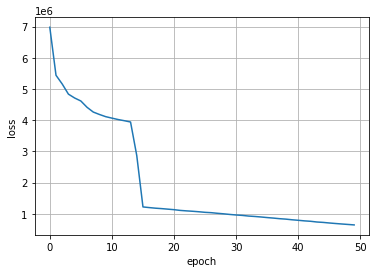

In [11]:
plt.plot(train_callback.loss)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()

### Results


In [12]:
# The most related
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('oooo', 0.3567364811897278),
 ('whaa', 0.3407559096813202),
 ('guidance', 0.33869025111198425),
 ('getaway', 0.33842137455940247),
 ('unusual', 0.3381232023239136),
 ('“oh', 0.3357376158237457),
 ('whoaa', 0.3337134122848511),
 ('discreet', 0.3321044147014618),
 ('bambi', 0.33016514778137207),
 ('inspire', 0.3293995261192322)]

In [13]:
# The least related
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('xxix', 0.11887381970882416),
 ('xxxvi', 0.10323155671358109),
 ('xvi', 0.10039831697940826),
 ('xii', 0.09784182906150818),
 ('xxxix', 0.09631551057100296),
 ('xxvii', 0.08722763508558273),
 ('xxxiii', 0.07976940274238586),
 ('ix', 0.06558245420455933),
 ('siedah', 0.05004114657640457),
 ('parade', 0.04586414992809296)]

In [14]:
# The most related
w2v_model.wv.most_similar(positive=["four"], topn=10)

[('twenty', 0.4172571897506714),
 ('whee', 0.3869883418083191),
 ('karat', 0.37435564398765564),
 ('swiftly', 0.3569449186325073),
 ('donate', 0.3537265956401825),
 ('seven', 0.3531298339366913),
 ('lopez', 0.3513649106025696),
 ('blackbirds', 0.34967344999313354),
 ('goon', 0.33422908186912537),
 ('dandelion', 0.3294452428817749)]

In [15]:
# The most related
w2v_model.wv.most_similar(positive=["money"], topn=5)

[('naire', 0.4115443229675293),
 ('forrest', 0.37579989433288574),
 ('wronger', 0.363911509513855),
 ("plottin'", 0.3621219992637634),
 ('maker', 0.3586929738521576)]

In [16]:
def reduce_dimensions(model, num_dimensions=2):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [17]:
vectors, labels = reduce_dimensions(w2v_model)
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]

MAX_WORDS = 200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [18]:
vectors, labels = reduce_dimensions(w2v_model, num_dimensions=3)
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
z_vals = [v[2] for v in vectors]

MAX_WORDS = 400
fig = px.scatter_3d(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], z=z_vals[:MAX_WORDS], text=labels[:MAX_WORDS], size_max=18, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show(renderer="colab")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

